In [ ]:
# 00_Setup & Data
import sys
!{sys.executable} -m pip install duckdb pandas numpy scikit-learn plotly ipywidgets

# 01_Import Libraries
import duckdb, pandas as pd, numpy as np
from sklearn.datasets import fetch_openml

adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.rename(columns={"class": "target"})
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
# Create a dedicated DuckDB connection and register the pandas DataFrame as a view/table
con = duckdb.connect()              # in-memory DB
con.register("adult_df", df)        # <-- IMPORTANT: lets SQL see your pandas DataFrame as 'adult_df'

# Quick row count + positive rate sanity check
con.sql("""
    SELECT 
      COUNT(*) AS n_rows,
      AVG(CASE WHEN target='>50K' THEN 1 ELSE 0 END)::DOUBLE AS pos_rate
    FROM adult_df
""").df()


,n_rows,pos_rate
0,48842,0.239282


In [6]:
# Target distribution
con.sql("""
    SELECT target, COUNT(*) AS n
    FROM adult_df
    GROUP BY target
    ORDER BY target
""").df()



,target,n
0,<=50K,37155
1,>50K,11687


In [7]:
# Numeric summary
con.sql("""
    SELECT 
      AVG(age) AS avg_age,
      AVG("hours-per-week") AS avg_hours,
      AVG("capital-gain") AS avg_cap_gain
    FROM adult_df
""").df()

,avg_age,avg_hours,avg_cap_gain
0,38.643585,40.422382,1079.067626


In [8]:
# Top categories
con.sql("""
    SELECT workclass, COUNT(*) AS n
    FROM adult_df
    GROUP BY workclass
    ORDER BY n DESC
    LIMIT 10
""").df()

,workclass,n
0,Private,33906
1,Self-emp-not-inc,3862
2,Local-gov,3136
3,NaN,2799
4,State-gov,1981
5,Self-emp-inc,1695
6,Federal-gov,1432
7,Without-pay,21
8,Never-worked,10


In [9]:
fe = con.sql("""
    WITH base AS (
        SELECT
            *,
            CASE WHEN education IN ('Bachelors','Masters','Doctorate') THEN 1 ELSE 0 END AS is_degree,
            CASE WHEN "hours-per-week" >= 50 THEN 1 ELSE 0 END AS long_hours,
            CASE WHEN "marital-status" LIKE 'Married-%' THEN 1 ELSE 0 END AS married_any,
            CASE 
              WHEN "capital-gain" = 0 THEN '0'
              WHEN "capital-gain" < 2000 THEN '0-2k'
              WHEN "capital-gain" < 5000 THEN '2-5k'
              WHEN "capital-gain" < 10000 THEN '5-10k'
              ELSE '10k+'
            END AS cap_gain_bucket
        FROM adult_df
    )
    SELECT * FROM base
""").df()

fe.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,is_degree,long_hours,married_any,cap_gain_bucket
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0,0,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0,1,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,0,0,1,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,0,0,1,5-10k
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K,0,0,0,0


In [10]:
con.sql("""
    SELECT target, COUNT(*) AS n
    FROM fe
    GROUP BY target
""").df()


,target,n
0,<=50K,37155
1,>50K,11687


In [11]:
# 02_Pipeline & Baselines
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix

X = fe.drop(columns=["target"])
y = (fe["target"] == ">50K").astype(int)

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    # numeric pass-through by default
], remainder="passthrough")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

baseline = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])
baseline.fit(X_train, y_train)
print("Baseline AUC:", roc_auc_score(y_test, baseline.predict_proba(X_test)[:,1]))


Baseline AUC: 0.7512071677517195


In [12]:
# Extract the trained DecisionTree from the pipeline
tree = baseline.named_steps["clf"]


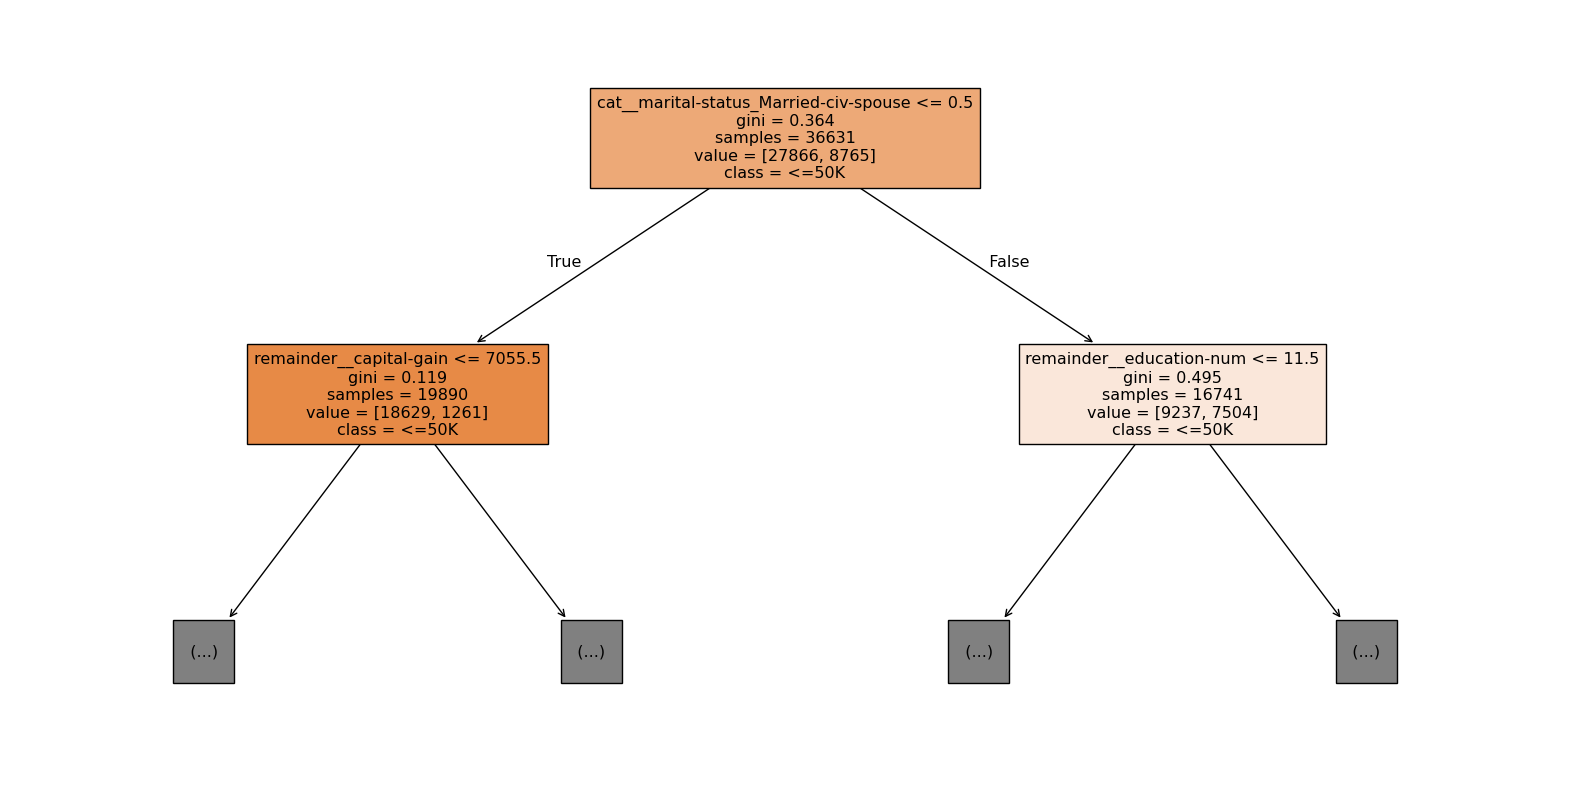

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=baseline.named_steps["prep"].get_feature_names_out(),
          class_names=["<=50K", ">50K"],
          filled=True,
          max_depth=1)   # limit depth for readability
plt.show()


In [14]:
# 03_Pre-Pruning Tuner (interactive)
import plotly.graph_objects as go
import ipywidgets as w




In [15]:
%pip install -U nbformat plotly ipywidgets



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import sys, nbformat, plotly
print("Python:", sys.executable)
print("nbformat:", nbformat.__version__)
print("plotly:", plotly.__version__)


Python: /usr/local/opt/python@3.11/bin/python3.11
nbformat: 5.10.4
plotly: 6.3.0


In [17]:
import plotly.io as pio
pio.renderers.default = "vscode"          

In [ ]:



# Pick a renderer that works in VS Code
pio.renderers.default = "vscode"  # or "plotly_mimetype" or "browser"

def evaluate_tree(max_depth=6, min_samples_leaf=5, min_samples_split=10):
    model = Pipeline([
        ("prep", preprocess),
        ("clf", DecisionTreeClassifier(
            max_depth=max_depth or None,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            random_state=42
        ))
    ])
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, proba)
    precision, recall, _ = precision_recall_curve(y_test, proba)
    auc_val = roc_auc_score(y_test, proba)

    # Build the figure normally
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name="ROC"))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode="lines",
                             name="Chance", line=dict(dash="dash")))
    fig.update_layout(title=f"Pre-Pruned ROC (AUC={auc_val:.3f})",
                      xaxis_title="FPR", yaxis_title="TPR")
    return fig  # ← return, don't .show() inside widget callbacks

w.interact(
    evaluate_tree,
    max_depth=w.IntSlider(value=6, min=2, max=30, step=1, description="max_depth"),
    min_samples_leaf=w.IntSlider(value=5, min=1, max=100, step=1, description="min_leaf"),
    min_samples_split=w.IntSlider(value=10, min=2, max=200, step=1, description="min_split"),
);


interactive(children=(IntSlider(value=6, description='max_depth', max=30, min=2), IntSlider(value=5, descripti…

In [21]:
# 04_Post-Pruning via Cost-Complexity
from sklearn.model_selection import StratifiedKFold, cross_val_score

# fit unpruned tree to get ccp_path on training folds
prep_only = preprocess.fit(X_train, y_train)
Xtr_prepped = prep_only.transform(X_train)
unpruned = DecisionTreeClassifier(random_state=42)
path = unpruned.cost_complexity_pruning_path(Xtr_prepped, y_train)
ccps = path.ccp_alphas

def post_prune(alpha_idx):
    alpha = float(ccps[alpha_idx])
    model = Pipeline([
        ("prep", preprocess),
        ("clf", DecisionTreeClassifier(random_state=42, ccp_alpha=alpha))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv).mean()
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    test_auc = roc_auc_score(y_test, proba)
    # Plot tree size vs alpha (approximate: refit on full train)
    # (Optional) also show number of leaves/depth by refitting a plain tree on transformed X
    t = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(Xtr_prepped, y_train)
    fig = go.Figure()
    fig.add_trace(go.Indicator(mode="number+delta",
        value=test_auc, delta={"reference": auc},
        title={"text": f"Test AUC (Δ vs CV) — α={alpha:.2e} | leaves={t.get_n_leaves()} | depth={t.get_depth()}"}
    ))
    fig.show()

w.interact(
    post_prune,
    alpha_idx=w.IntSlider(value=0, min=0, max=len(ccps)-1, step=1, description="alpha_idx")
);


interactive(children=(IntSlider(value=0, description='alpha_idx', max=1906), Output()), _dom_classes=('widget-…

In [22]:
# 05_Diagnostics with threshold slider
import itertools

best_model = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_leaf=10))
]).fit(X_train, y_train)
proba_test = best_model.predict_proba(X_test)[:,1]

def plot_confusion(threshold):
    y_hat = (proba_test >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_hat)
    fig = go.Figure(data=go.Heatmap(z=cm, x=["Pred 0","Pred 1"], y=["True 0","True 1"], text=cm, texttemplate="%{text}"))
    fig.update_layout(title=f"Confusion Matrix @ threshold={threshold:.2f}")
    fig.show()

    prec = (cm[1,1] / (cm[0,1] + cm[1,1])) if (cm[0,1] + cm[1,1])>0 else 0
    rec  = (cm[1,1] / (cm[1,0] + cm[1,1])) if (cm[1,0] + cm[1,1])>0 else 0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0
    print(f"Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

w.interact(plot_confusion, threshold=w.FloatSlider(value=0.5, min=0.05, max=0.95, step=0.01))


interactive(children=(FloatSlider(value=0.5, description='threshold', max=0.95, min=0.05, step=0.01), Output()…

<function __main__.plot_confusion(threshold)>